Gauge Center: (122, 127), Radius: 105


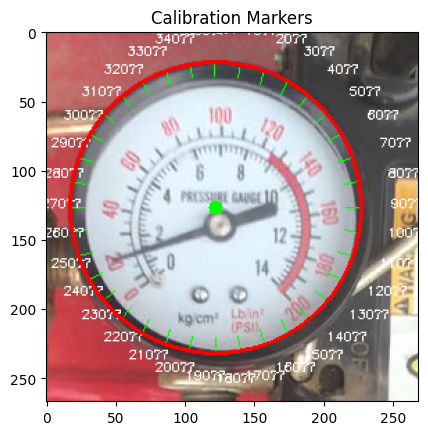

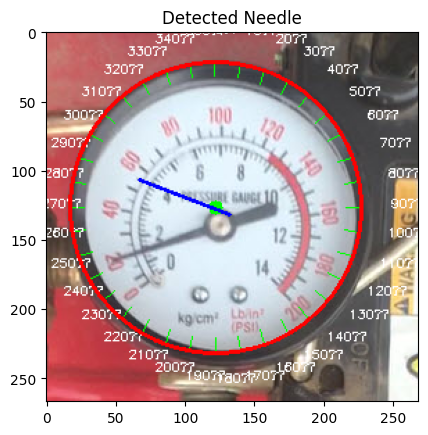

Needle Angle: 333.43°
Detected Angle: 333.43°
Calibration Range: 230° to 140°
Error: Angle out of calibration range!


In [4]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

def dist_2_pts(x1, y1, x2, y2):
    """Calculate distance between two points."""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def find_gauge(img, gauge_pixels_radius):
    """Detect the circular gauge in the image."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30,
        minRadius=int(gauge_pixels_radius * 0.9), maxRadius=int(gauge_pixels_radius * 1.1)
    )
    if circles is None:
        raise Exception("Gauge circle not detected!")
    circles = np.round(circles[0, :]).astype("int")
    x, y, r = circles[0]
    print(f"Gauge Center: ({x}, {y}), Radius: {r}")
    return x, y, r

def calibrate_gauge(img, x, y, r):
    """Display calibration markers on the gauge."""
    separation = 10.0  # Degrees between markers
    interval = int(360 / separation)

    # Draw lines and text markers
    for i in range(interval):
        angle_rad = math.radians(i * separation)
        x_inner = int(x + 0.9 * r * math.cos(angle_rad))
        y_inner = int(y + 0.9 * r * math.sin(angle_rad))
        x_outer = int(x + r * math.cos(angle_rad))
        y_outer = int(y + r * math.sin(angle_rad))
        cv2.line(img, (x_inner, y_inner), (x_outer, y_outer), (0, 255, 0), 1)

        # Text markers
        text_angle = (i * separation + 90) % 360
        text_x = int(x + 1.2 * r * math.cos(angle_rad))
        text_y = int(y + 1.2 * r * math.sin(angle_rad))
        cv2.putText(img, f'{int(text_angle)}°', (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

    # Draw the detected circle
    cv2.circle(img, (x, y), r, (0, 0, 255), 2)
    cv2.circle(img, (x, y), 5, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Calibration Markers")
    plt.show()

def get_needle_angle(img, x, y, r):
    """Detect the needle and calculate its angle."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)
    lines = cv2.HoughLinesP(thresh, rho=1, theta=np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)
    
    if lines is None:
        raise Exception("Needle not detected!")
    
    # Find the best line (closest to the gauge center)
    needle_line = None
    min_dist = float("inf")
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist_to_center = min(dist_2_pts(x, y, x1, y1), dist_2_pts(x, y, x2, y2))
        if dist_to_center < min_dist:
            min_dist = dist_to_center
            needle_line = (x1, y1, x2, y2)
    
    x1, y1, x2, y2 = needle_line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Needle")
    plt.show()

    # Calculate angle
    dx, dy = x2 - x, y - y2  # Flip y-axis for correct angle
    angle = math.degrees(math.atan2(dy, dx))
    if angle < 0:
        angle += 360
    print(f"Needle Angle: {angle:.2f}°")
    return angle

def map_angle_to_value(angle, min_angle, max_angle, min_value, max_value):
    """Map the angle to a gauge value based on calibration."""
    print(f"Detected Angle: {angle:.2f}°")
    print(f"Calibration Range: {min_angle}° to {max_angle}°")
    if angle < min_angle or angle > max_angle:
        raise Exception("Angle out of calibration range!")
    angle_range = max_angle - min_angle
    value_range = max_value - min_value
    value = min_value + ((angle - min_angle) / angle_range) * value_range
    print(f"Gauge Value: {value:.2f}")
    return value

def read_gauge(img_path, gauge_pixels_radius, min_angle, max_angle, min_value, max_value):
    """Main function to read the analog gauge."""
    img = cv2.imread(img_path)
    if img is None:
        raise Exception("Image not found or invalid file path.")
    x, y, r = find_gauge(img, gauge_pixels_radius)
    calibrate_gauge(img, x, y, r)
    angle = get_needle_angle(img, x, y, r)
    value = map_angle_to_value(angle, min_angle, max_angle, min_value, max_value)
    return angle, value

# Example usage
if __name__ == "__main__":
    # Image of the gauge
    gauge_image = "gauge-1.jpg"  # Replace with your image path
    gauge_pixels_radius = 100  # Approximate radius in pixels

    # Calibration parameters
    min_angle = 230  # Angle for minimum value (e.g., 0)
    max_angle = 140  # Angle for maximum value (e.g., 200)
    min_value = 0  # Minimum gauge value
    max_value = 200  # Maximum gauge value

    try:
        angle, value = read_gauge(gauge_image, gauge_pixels_radius, min_angle, max_angle, min_value, max_value)
        print(f"Needle Angle: {angle:.2f}°")
        print(f"Gauge Value: {value:.2f}")
    except Exception as e:
        print(f"Error: {e}")
